In [1]:
import pandas as pd
import glob
import xarray as xr
import numpy as np
from statsmodels.stats.anova import AnovaRM 
from scipy import stats
from matplotlib import pyplot as plt
import pingouin as pg
import numpy as np
import seaborn as sns
import scipy

In [2]:
vn = ['fusiform-rh', 'fusiform-lh', 'lingual-lh', 'lingual-rh',
'cuneus-rh','cuneus-lh', 'lateraloccipital-rh', 'lateraloccipital-lh']

methods = ['coh','ciplv','imcoh','wpli2']

In [3]:
#assembling variance dictionaries

inter_variance_dict = {}
intra_variance_dict = {}

intra_upper_outlier_dict = {}
intra_lower_outlier_dict = {}

inter_upper_outlier_dict = {}
inter_lower_outlier_dict = {}

for method in methods: 
    subject_files = glob.glob(f'/Users/lina_01/Desktop/mpi_lemon/undirected_outputs/{method}/*_EC.nc')

    #intra
    
    mean_per_subject = []
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        std_mean_list = []
        for sample in range(0,100):
            std = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values.std()
            mean = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values.mean()
            std_mean_list.append(std/mean)
        mean_per_subject.append(np.mean(std_mean_list))
    intra_variance_dict[method] = mean_per_subject

    #outliers - INTRA
    
    q1 = np.percentile(intra_variance_dict[method], 25, method='midpoint')
    q3 = np.percentile(intra_variance_dict[method], 75, method='midpoint')
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    upper_array = np.where(intra_variance_dict[method] >= upper)[0]
    lower_array = np.where(intra_variance_dict[method] <= lower)[0]
    intra_upper_outlier_dict[method] = upper_array
    intra_lower_outlier_dict[method] = lower_array
    
    #inter
    
    all_bootstraps = []  #list of 11200 arrays
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        for sample in range(0,100):
            bootstrap = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values
            all_bootstraps.append(bootstrap)
    
    random_bootstraps = []
    for i in range(0,112):
        index = np.random.choice(range(0,11200),100)
        sample = np.array(all_bootstraps)[index,:]
        random_bootstraps.append(sample)

    mean_per_bootstrap = []
    for sample in random_bootstraps:
        std_mean_list = []
        for i in range(0,100):
            std = sample[i].std()
            mean = sample[i].mean()
            std_mean_list.append(std/mean)
    
        mean_per_bootstrap.append(np.mean(std_mean_list))
    
    inter_variance_dict[method] = mean_per_bootstrap

    #outlier indices - INTER
    
    q1 = np.percentile(intra_variance_dict[method], 25, method='midpoint')
    q3 = np.percentile(intra_variance_dict[method], 75, method='midpoint')
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    upper_array = np.where(inter_variance_dict[method] >= upper)[0]
    lower_array = np.where(inter_variance_dict[method] <= lower)[0]
    inter_upper_outlier_dict[method] = upper_array
    inter_lower_outlier_dict[method] = lower_array

#removing outliers - inter

for method in methods:
    
    all_outlier_indices = []
    
    for index in inter_upper_outlier_dict[method]:
        if index not in all_outlier_indices:
            all_outlier_indices.append(index)

    for index in inter_lower_outlier_dict[method]:
        if index not in all_outlier_indices:
            all_outlier_indices.append(index)
            
    outlier_removed = []
    
    for i in range(0,112):
        if i not in all_outlier_indices:
            outlier_removed.append(inter_variance_dict[method][i])
            
    inter_variance_dict[method] = outlier_removed

#removing outliers - intra

for method in methods:
    
    all_outlier_indices = []
    
    for index in intra_upper_outlier_dict[method]:
        if index not in all_outlier_indices:
            all_outlier_indices.append(index)

    for index in intra_lower_outlier_dict[method]:
        if index not in all_outlier_indices:
            all_outlier_indices.append(index)
            
    outlier_removed = []
    
    for i in range(0,112):
        if i not in all_outlier_indices:
            outlier_removed.append(intra_variance_dict[method][i])
            
    intra_variance_dict[method] = outlier_removed

In [4]:
##CHECK SAMPLE SIZES OF DICTIONARIES
for method in methods:
    print(method, len(inter_variance_dict[method]))

coh 112
ciplv 112
imcoh 98
wpli2 90


In [5]:
## CHECK SAMPLE SIZES OF DICTIONARIES
for method in methods:
    print(method, len(intra_variance_dict[method]))

coh 109
ciplv 106
imcoh 95
wpli2 93


In [ ]:
#BOOTSTRAP T STATISTIC TO COMPARE INTER- AND INTRA- VARIANCE DICTIONARIES (UNEQUAL SAMPLES)

In [6]:
p_val_dict = {}

for method in methods:
    
    #calculate original t statistic
    mean1 = np.mean(inter_variance_dict[method])
    mean2 = np.mean(intra_variance_dict[method])
    
    sd1 = np.std(inter_variance_dict[method])
    sd2 = np.std(intra_variance_dict[method])
    
    #calculate length of inter
    n1 = len(inter_variance_dict[method])
    
    #calculate length of intra
    n2 = len(intra_variance_dict[method])
    
    #calculate total n
    total_n = n1 + n2
    
    pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))
    
    t_orig = (mean1 - mean2)/(pooled_sd * np.sqrt((1/n1) + (1/n2)))
    
    #create pooled sample
    pooled_sample = inter_variance_dict[method] + intra_variance_dict[method]
    
    ####################################################
    #sample from pooled 1000 times
    bootstrap_sample1 = []
    bootstrap_sample2 = []
    
    for i in range(1000):
        sample1 = []
        sample2 = []
        index1 = np.random.choice(range(0,total_n),n1)
        index2 = np.random.choice(range(0,total_n),n2)
        sample1 = np.array(pooled_sample)[index1]
        sample2 = np.array(pooled_sample)[index2]
        bootstrap_sample1.append(sample1)
        bootstrap_sample2.append(sample2)
        
    #calculate the t-statistic in each
    bootstrap_t_stats = []
    for i in range(1000):
        mean1 = np.mean(bootstrap_sample1[i])
        mean2 = np.mean(bootstrap_sample2[i])
        
        sd1 = np.std(bootstrap_sample1[i])
        sd2 = np.std(bootstrap_sample2[i])
        
        n1 = len(bootstrap_sample1[i])
        n2 = len(bootstrap_sample2[i])
        
        pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))
        
        t = (mean1 - mean2)/(pooled_sd * np.sqrt((1/n1) + (1/n2)))
    
        bootstrap_t_stats.append(t)
    
    count = 0
    for t in bootstrap_t_stats:
        if t > t_orig:
            count += 1

    p_val = count/1000
    p_val_corr = p_val * 4
    p_val_dict[method] = p_val_corr

In [7]:
p_val_dict

{'coh': 0.56, 'ciplv': 0.828, 'imcoh': 1.004, 'wpli2': 1.412}

In [ ]:
#STATISTICAL TESTING FOR DIFFERENCE IN VARIANCE BETWEEN INTER-VARIANCE-DICTIONARIES AND INTRA-VARIANCE DICTIONARIES

In [ ]:
#BOOTSTRAP T STATISTIC (UNEQUAL SAMPLES)

In [8]:
comparison_pairs = [('coh','ciplv'), ('coh','imcoh'), ('coh','wpli2'), ('ciplv','imcoh'),('ciplv','wpli2'),('imcoh','wpli2')]

In [9]:
p_vals_overall = []

for variance_dict in [inter_variance_dict, intra_variance_dict]:

    p_val_dict = {}

    for pair in comparison_pairs:
        method1 = pair[0]
        method2 = pair[1]
    
        sample_size1 = len(variance_dict[method1])
        sample_size2 = len(variance_dict[method2])
        total_sample_size = sample_size1 + sample_size2
    
        mean1 = np.mean(variance_dict[method1])
        mean2 = np.mean(variance_dict[method2])
        
        sd1 = np.std(variance_dict[method1])
        sd2 = np.std(variance_dict[method2])
        
        n1 = len(variance_dict[method1])
        n2 = len(variance_dict[method2])
        
        pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))
        
        t_orig = (mean1 - mean2)/(pooled_sd * np.sqrt((1/n1) + (1/n2)))
    
        pooled_sample = variance_dict[method1] + variance_dict[method2]
    
        bootstrap_sample1 = []
        bootstrap_sample2 = []
        
        for i in range(1000):
            sample1 = []
            sample2 = []
            index1 = np.random.choice(range(0,total_sample_size),sample_size1)
            index2 = np.random.choice(range(0,total_sample_size),sample_size2)
            sample1 = np.array(pooled_sample)[index1]
            sample2 = np.array(pooled_sample)[index2]
            bootstrap_sample1.append(sample1)
            bootstrap_sample2.append(sample2)

        bootstrap_t_stats = []
        for i in range(1000):
            mean1 = np.mean(bootstrap_sample1[i])
            mean2 = np.mean(bootstrap_sample2[i])
            
            sd1 = np.std(bootstrap_sample1[i])
            sd2 = np.std(bootstrap_sample2[i])
            
            n1 = len(bootstrap_sample1[i])
            n2 = len(bootstrap_sample2[i])
            
            pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))
            
            t = (mean1 - mean2)/(pooled_sd * np.sqrt((1/n1) + (1/n2)))
        
            bootstrap_t_stats.append(t)
        
        count = 0
        for t in bootstrap_t_stats:
            if t > t_orig:
                count += 1
        
        p_val = count/1000

        p_val_corr = p_val * 12 #(bonferroni correction)
        
        p_val_dict[pair] = p_val_corr
        
    p_vals_overall.append(p_val_dict)

In [10]:
p_vals_overall

[{('coh', 'ciplv'): 0.0,
  ('coh', 'imcoh'): 6.0120000000000005,
  ('coh', 'wpli2'): 12.0,
  ('ciplv', 'imcoh'): 5.952,
  ('ciplv', 'wpli2'): 12.0,
  ('imcoh', 'wpli2'): 11.016},
 {('coh', 'ciplv'): 1.62,
  ('coh', 'imcoh'): 2.1719999999999997,
  ('coh', 'wpli2'): 12.0,
  ('ciplv', 'imcoh'): 2.088,
  ('ciplv', 'wpli2'): 12.0,
  ('imcoh', 'wpli2'): 11.904}]

In [ ]:
#EXAMINING DISTRIBUTIONS TO UNDERSTAND SIGNIFICANCE

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

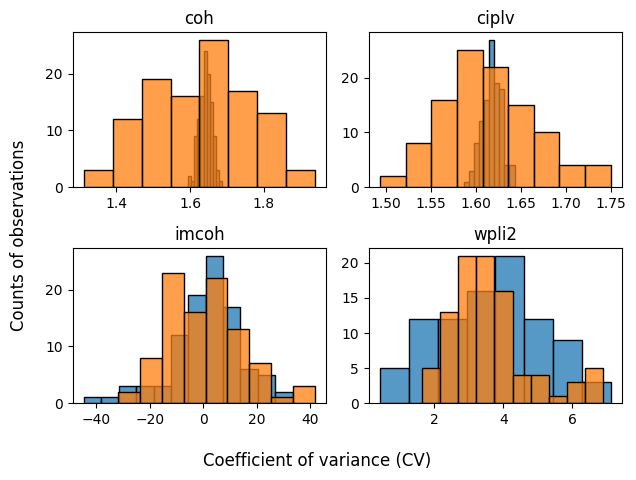

In [69]:
#4-panel figure to show inter vs intra differences for each method
fig, axes = plt.subplots(2,2)
for method, ax in list(zip(methods,axes.ravel())):
    sns.histplot(inter_variance_dict[method], ax=ax)
    sns.histplot(intra_variance_dict[method], ax=ax)
    ax.set_ylabel("")
    ax.set_title(method)

fig.supxlabel('Coefficient of variance (CV)')
fig.supylabel('Counts of observations')
fig.tight_layout()

    #Remove axes labels
    #Add legends
    #Add x axis label
    #Add titles to each plot

In [ ]:
#1 figure to show inter variance distribution with inlaid panel


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

(<matplotlib.patches.Rectangle at 0x2bd9adf10>,
 (<matplotlib.patches.ConnectionPatch at 0x2bdce3150>,
  <matplotlib.patches.ConnectionPatch at 0x2bdc17710>))

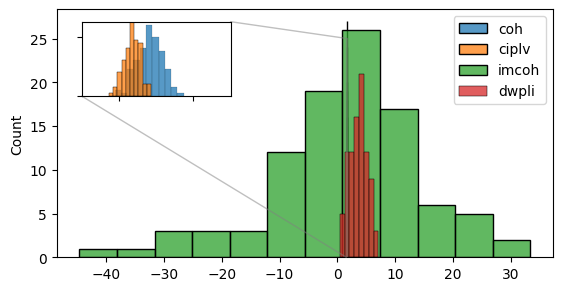

In [70]:
fig, main_ax = plt.subplots(); main_ax.set_box_aspect(0.5) 
inset_ax = main_ax.inset_axes(
   [0.05, 0.65, 0.3, 0.3],  # [x, y, width, height] w.r.t. axes
    xlim=[4,5], ylim=[4, 5], # sets viewport &amp; tells relation to main axes
    xticklabels=[], yticklabels=[]
)

# add plot content

sns.histplot(inter_variance_dict['coh'], ax=main_ax, label='coh')
sns.histplot(inter_variance_dict['coh'], ax=inset_ax)
inset_ax.set_xlim(1.55,1.75)
inset_ax.set_ylim(0,25)
inset_ax.set_ylabel('')

sns.histplot(inter_variance_dict['ciplv'], ax=main_ax, label='ciplv')
sns.histplot(inter_variance_dict['ciplv'], ax=inset_ax)
inset_ax.set_xlim(1.55,1.75)
inset_ax.set_ylim(0,25)
inset_ax.set_ylabel('')

sns.histplot(inter_variance_dict['imcoh'], ax=main_ax, label='imcoh')

sns.histplot(inter_variance_dict['wpli2'], ax=main_ax, label='dwpli')

main_ax.legend()

# add zoom leaders
main_ax.indicate_inset_zoom(inset_ax)

In [ ]:
#1 figure to show intra variance distribution with inlaid panel

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

(<matplotlib.patches.Rectangle at 0x2be01c390>,
 (<matplotlib.patches.ConnectionPatch at 0x2be0db150>,
  <matplotlib.patches.ConnectionPatch at 0x2be01e9d0>))

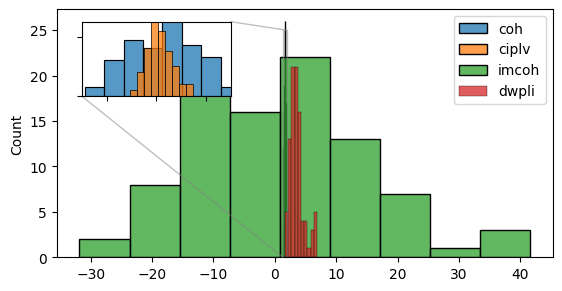

In [74]:
fig, main_ax = plt.subplots(); main_ax.set_box_aspect(0.5) 
inset_ax = main_ax.inset_axes(
   [0.05, 0.65, 0.3, 0.3],  # [x, y, width, height] w.r.t. axes
    xlim=[4,5], ylim=[4, 5], # sets viewport &amp; tells relation to main axes
    xticklabels=[], yticklabels=[]
)

# add plot content

sns.histplot(intra_variance_dict['coh'], ax=main_ax, label='coh')
sns.histplot(intra_variance_dict['coh'], ax=inset_ax)
inset_ax.set_xlim(1.3,1.9)
inset_ax.set_ylim(0,25)
inset_ax.set_ylabel('')

sns.histplot(intra_variance_dict['ciplv'], ax=main_ax, label='ciplv')
sns.histplot(intra_variance_dict['ciplv'], ax=inset_ax)
inset_ax.set_xlim(1.3,1.9)
inset_ax.set_ylim(0,25)
inset_ax.set_ylabel('')

sns.histplot(intra_variance_dict['imcoh'], ax=main_ax, label='imcoh')

sns.histplot(intra_variance_dict['wpli2'], ax=main_ax, label='dwpli')

main_ax.legend()

# add zoom leaders
main_ax.indicate_inset_zoom(inset_ax)